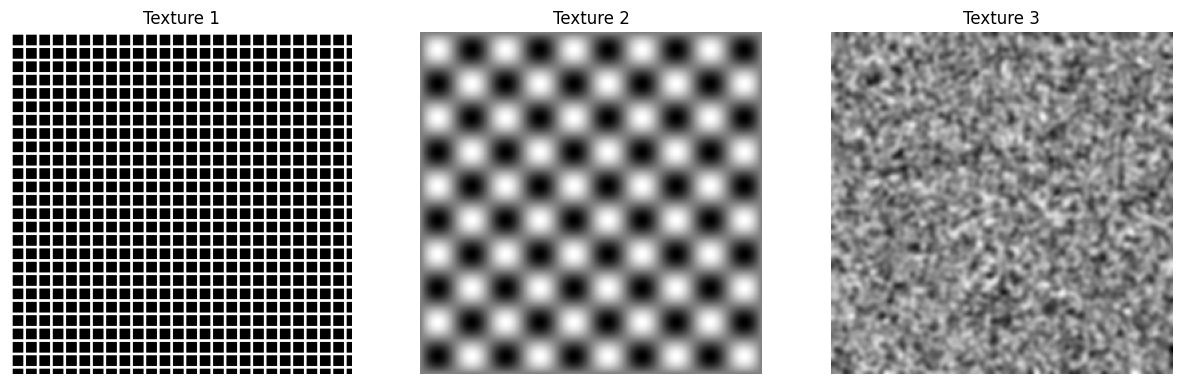

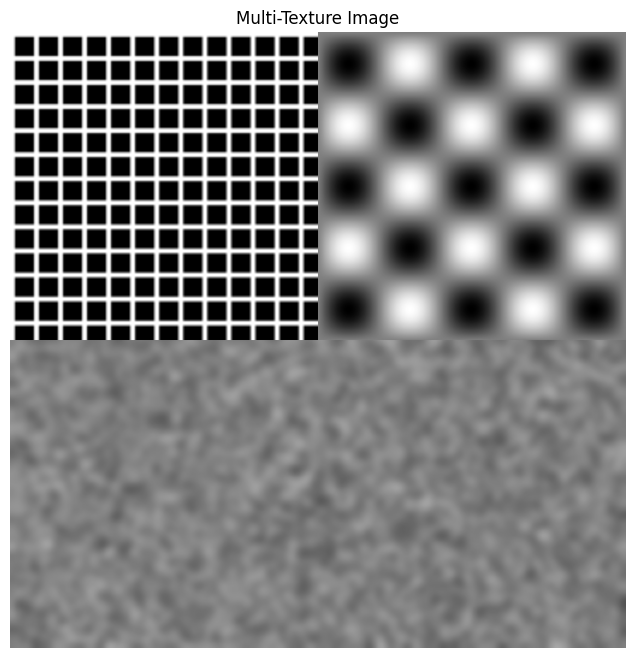

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.util import img_as_float
from scipy import ndimage as ndi
from sklearn.cluster import KMeans
import cv2

def generate_textures(size=256, num_textures=3):
    """Generate synthetic textures using different patterns"""
    textures = []

    texture1 = np.zeros((size, size))
    for i in range(0, size, 10):
        texture1[:, i:i+2] = 1
        texture1[i:i+2, :] = 1
    textures.append(texture1)

    x, y = np.meshgrid(np.linspace(0, 10*np.pi, size), np.linspace(0, 10*np.pi, size))
    texture2 = np.sin(x) * np.sin(y)
    texture2 = (texture2 + 1) / 2
    textures.append(texture2)

    texture3 = np.random.rand(size, size)
    texture3 = ndi.gaussian_filter(texture3, sigma=2)
    textures.append(texture3)

    for i in range(3, num_textures):
        freq = np.random.uniform(0.1, 0.5)
        angle = np.random.uniform(0, np.pi)
        x_rot = x * np.cos(angle) + y * np.sin(angle)
        texture = np.sin(freq * x_rot)
        texture = (texture + 1) / 2
        textures.append(texture)

    return textures

def create_multitexture_image(textures, size=512):
    """Create a multi-texture image from individual textures"""

    multi_texture = np.zeros((size, size))

    masks = []

    mask1 = np.zeros((size, size), dtype=bool)
    mask1[:size//2, :size//2] = True
    masks.append(mask1)

    mask2 = np.zeros((size, size), dtype=bool)
    mask2[:size//2, size//2:] = True
    masks.append(mask2)

    mask3 = np.zeros((size, size), dtype=bool)
    mask3[size//2:, :] = True
    masks.append(mask3)

    for i, (texture, mask) in enumerate(zip(textures, masks)):

        if texture.shape[0] != size:
            texture = cv2.resize(texture, (size, size))

        multi_texture[mask] = texture[mask]

    return multi_texture, masks

textures = generate_textures(size=256, num_textures=3)
multi_texture_image, true_masks = create_multitexture_image(textures, size=512)

plt.figure(figsize=(15, 5))
for i, texture in enumerate(textures):
    plt.subplot(1, 3, i+1)
    plt.imshow(texture, cmap='gray')
    plt.title(f'Texture {i+1}')
    plt.axis('off')

plt.figure(figsize=(8, 8))
plt.imshow(multi_texture_image, cmap='gray')
plt.title('Multi-Texture Image')
plt.axis('off')
plt.show()

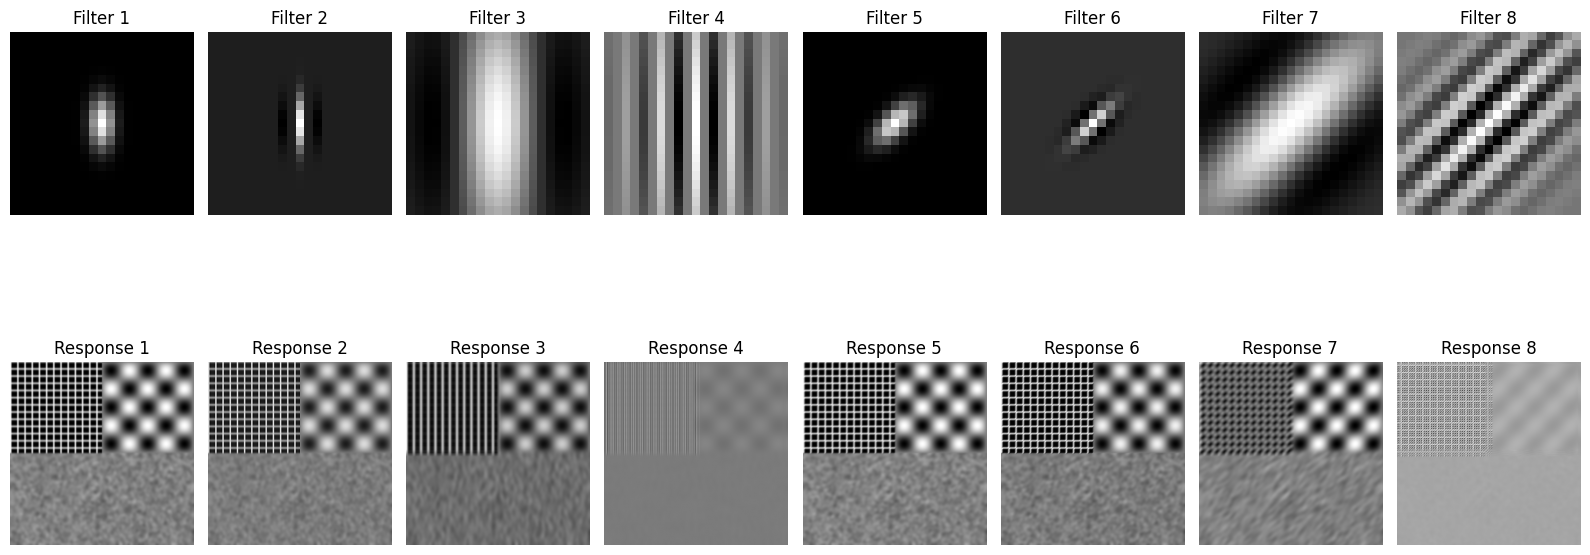

In [5]:
def build_gabor_filters(num_orientations=8, num_scales=5, ksize=31):
    """Build a bank of Gabor filters with different orientations and scales"""
    filters = []

    for theta in np.linspace(0, np.pi, num_orientations, endpoint=False):
        for sigma in np.linspace(1, 5, num_scales):
            for frequency in [0.05, 0.25]:
                kernel = cv2.getGaborKernel(
                    (ksize, ksize),
                    sigma=sigma,
                    theta=theta,
                    lambd=1.0/frequency,
                    gamma=0.5,
                    psi=0,
                    ktype=cv2.CV_32F
                )
                kernel /= np.sum(np.abs(kernel))
                filters.append(kernel)

    return filters

def extract_gabor_features(image, filters):
    """Extract Gabor features from an image using a bank of filters"""

    if image.max() > 1.0:
        image = image / 255.0

    features = np.zeros((image.shape[0], image.shape[1], len(filters), 2), dtype=np.float32)

    for i, kernel in enumerate(filters):

        filtered = cv2.filter2D(image, cv2.CV_32F, kernel)

        features[:, :, i, 0] = filtered

        local_var = np.zeros_like(filtered)
        for y in range(2, image.shape[0]-2):
            for x in range(2, image.shape[1]-2):
                patch = filtered[y-2:y+3, x-2:x+3]
                local_var[y, x] = np.var(patch)

        features[:, :, i, 1] = local_var

    num_pixels = image.shape[0] * image.shape[1]
    num_features = len(filters) * 2
    features_reshaped = features.reshape(num_pixels, num_features)

    return features_reshaped, features

gabor_filters = build_gabor_filters(num_orientations=4, num_scales=2, ksize=21)



gabor_features, feature_maps = extract_gabor_features(multi_texture_image, gabor_filters)

plt.figure(figsize=(16, 8))

num_filters_to_show = min(8, len(gabor_filters))

for i in range(num_filters_to_show):

    plt.subplot(2, num_filters_to_show, i+1)
    plt.imshow(gabor_filters[i], cmap='gray')
    plt.title(f'Filter {i+1}')
    plt.axis('off')


    plt.subplot(2, num_filters_to_show, i+1+num_filters_to_show)
    plt.imshow(feature_maps[:, :, i, 0], cmap='gray')
    plt.title(f'Response {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


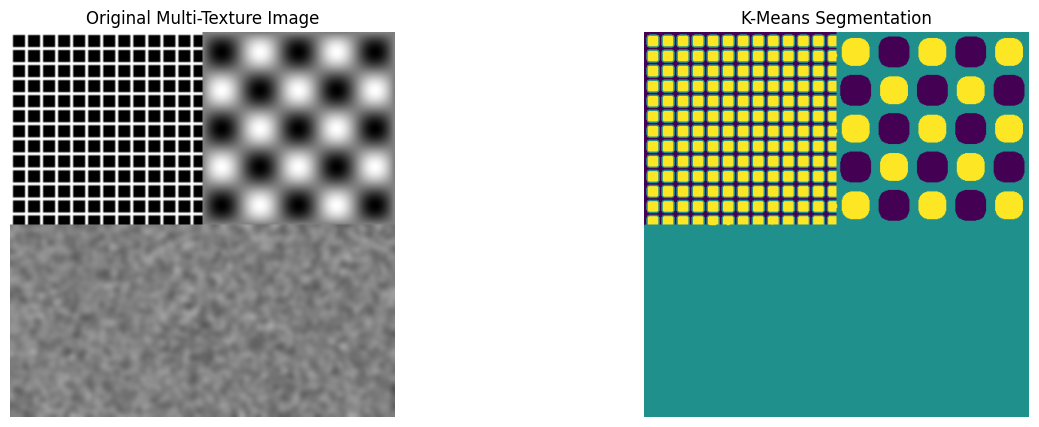

In [6]:
def segment_with_kmeans(features, num_clusters, image_shape):
    """Segment an image using K-Means clustering on Gabor features"""

    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(features)

    segmented_image = cluster_labels.reshape(image_shape)

    return segmented_image, kmeans.cluster_centers_

def visualize_segmentation(original_image, segmented_image, true_masks=None):
    """Visualize the segmentation results"""
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Multi-Texture Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image, cmap='viridis')
    plt.title('K-Means Segmentation')
    plt.axis('off')


    plt.show()

num_clusters = 3
segmented_image, cluster_centers = segment_with_kmeans(
    gabor_features, num_clusters, multi_texture_image.shape
)

visualize_segmentation(multi_texture_image, segmented_image, true_masks)

Segmentation Accuracy: 68.75%


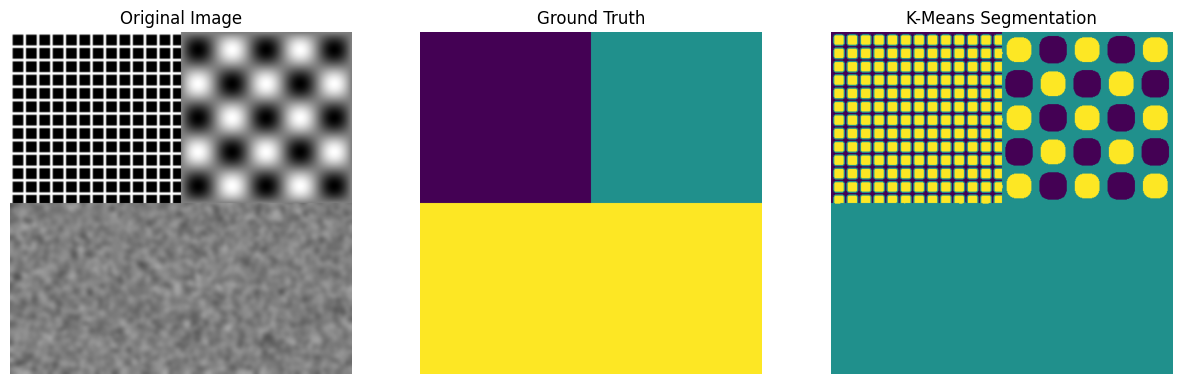

In [4]:
def evaluate_segmentation(segmented_image, true_masks, num_clusters):
    """Evaluate segmentation quality by comparing with ground truth"""

    ground_truth = np.zeros_like(segmented_image)
    for i, mask in enumerate(true_masks):
        ground_truth[mask] = i

    best_accuracy = 0

    import itertools
    for perm in itertools.permutations(range(num_clusters)):
        mapped_segmentation = np.zeros_like(segmented_image)
        for i, p in enumerate(perm):
            mapped_segmentation[segmented_image == i] = p

        accuracy = np.sum(mapped_segmentation == ground_truth) / ground_truth.size
        if accuracy > best_accuracy:
            best_accuracy = accuracy

    print(f"Segmentation Accuracy: {best_accuracy * 100:.2f}%")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(multi_texture_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth, cmap='viridis')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(segmented_image, cmap='viridis')
    plt.title('K-Means Segmentation')
    plt.axis('off')

    plt.show()

    return best_accuracy

accuracy = evaluate_segmentation(segmented_image, true_masks, num_clusters)

Generating textures...
Building Gabor filter bank...
Extracting Gabor features...
Performing K-Means clustering...
Visualizing results...


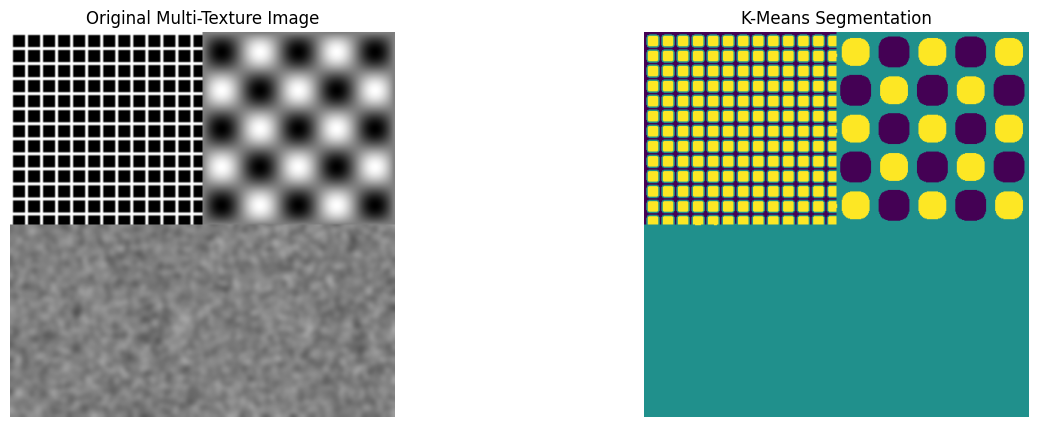

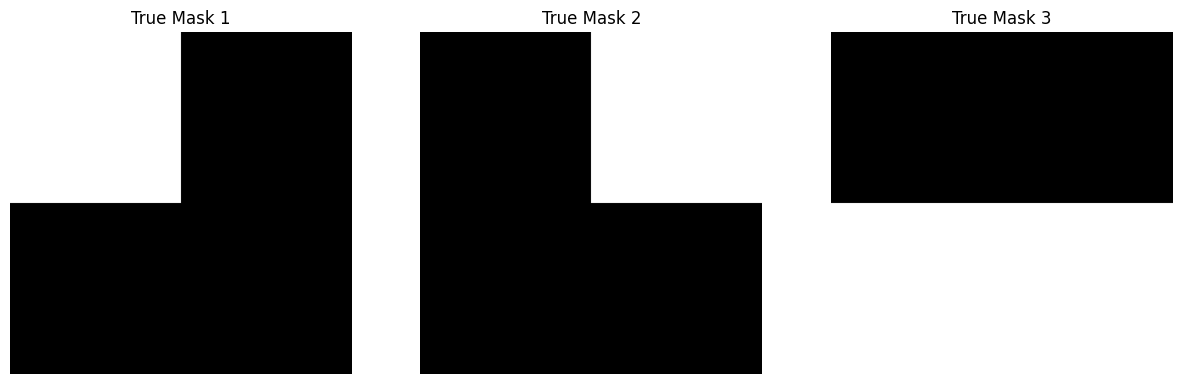

Evaluating segmentation...
Segmentation Accuracy: 68.76%


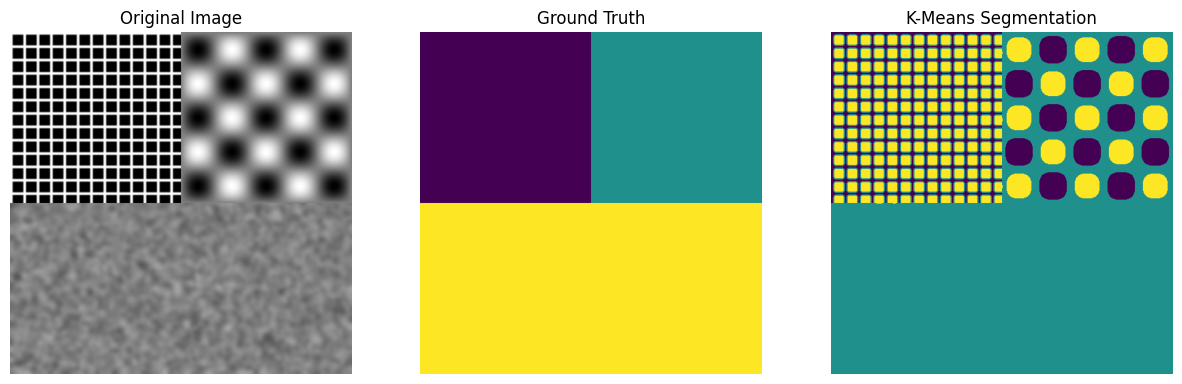

In [5]:
def texture_segmentation_pipeline(size=512, num_textures=3, num_clusters=3,
                                  num_orientations=4, num_scales=2):
    """Complete pipeline for texture generation, feature extraction, and segmentation"""

    print("Generating textures...")
    textures = generate_textures(size=size//2, num_textures=num_textures)
    multi_texture_image, true_masks = create_multitexture_image(textures, size=size)

    print("Building Gabor filter bank...")
    gabor_filters = build_gabor_filters(num_orientations=num_orientations,
                                        num_scales=num_scales,
                                        ksize=21)

    print("Extracting Gabor features...")
    gabor_features, feature_maps = extract_gabor_features(multi_texture_image, gabor_filters)

    print("Performing K-Means clustering...")
    segmented_image, cluster_centers = segment_with_kmeans(
        gabor_features, num_clusters, multi_texture_image.shape
    )

    print("Visualizing results...")
    visualize_segmentation(multi_texture_image, segmented_image, true_masks)

    print("Evaluating segmentation...")
    accuracy = evaluate_segmentation(segmented_image, true_masks, num_clusters)

    return {
        'textures': textures,
        'multi_texture_image': multi_texture_image,
        'true_masks': true_masks,
        'gabor_filters': gabor_filters,
        'feature_maps': feature_maps,
        'segmented_image': segmented_image,
        'cluster_centers': cluster_centers,
        'accuracy': accuracy
    }


results = texture_segmentation_pipeline(size=512, num_textures=3, num_clusters=3)

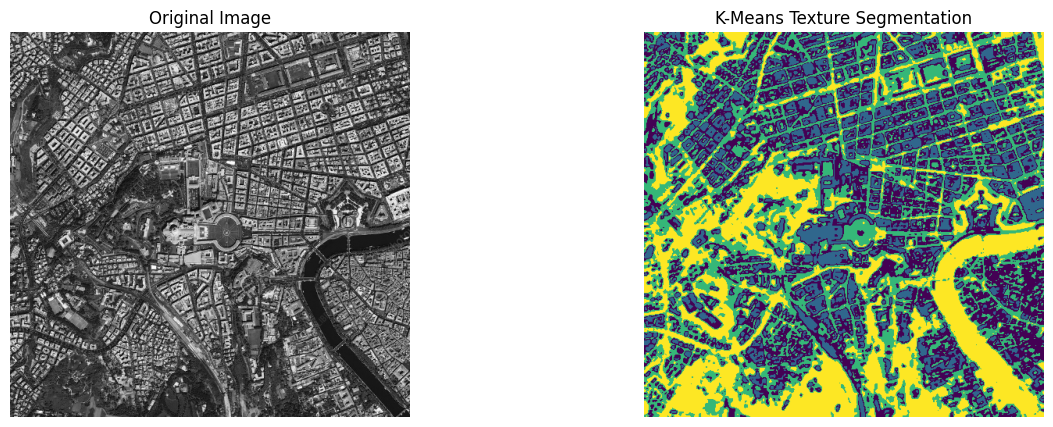

In [6]:
def segment_real_image(image_path, num_clusters=3, num_orientations=4, num_scales=2):
    """Apply texture segmentation to a real-world image"""

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Could not read image from {image_path}")

    max_dim = 512
    if max(image.shape) > max_dim:
        scale = max_dim / max(image.shape)
        image = cv2.resize(image, None, fx=scale, fy=scale)

    image = image / 255.0

    gabor_filters = build_gabor_filters(num_orientations=num_orientations,
                                      num_scales=num_scales,
                                      ksize=21)

    gabor_features, _ = extract_gabor_features(image, gabor_filters)

    segmented_image, _ = segment_with_kmeans(
        gabor_features, num_clusters, image.shape
    )

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image, cmap='viridis')
    plt.title('K-Means Texture Segmentation')
    plt.axis('off')

    plt.show()

    return segmented_image

segmented_image = segment_real_image("/content/800wm.jpeg", num_clusters=4)

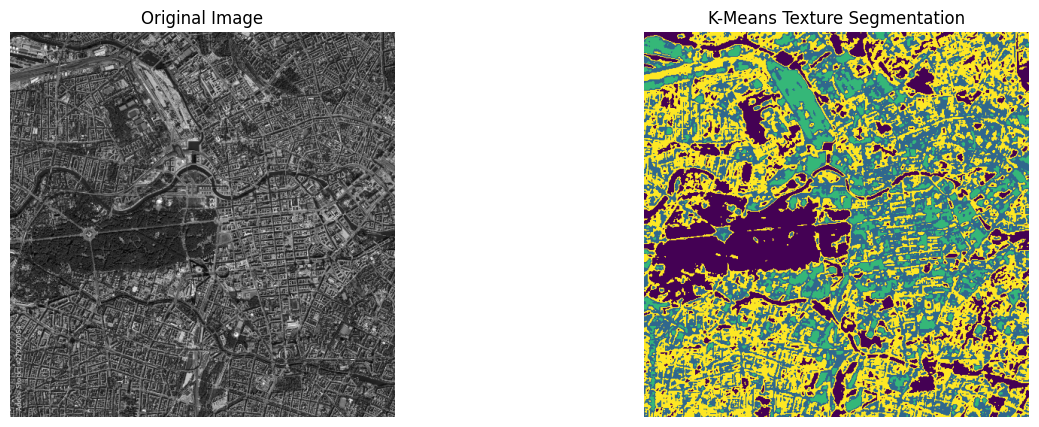

In [12]:
segmented_image = segment_real_image("/content/1000_F_279270054_LbUutS2fZIcEeAwUKLPTMRbKBzU9eXkp.jpg", num_clusters=4)

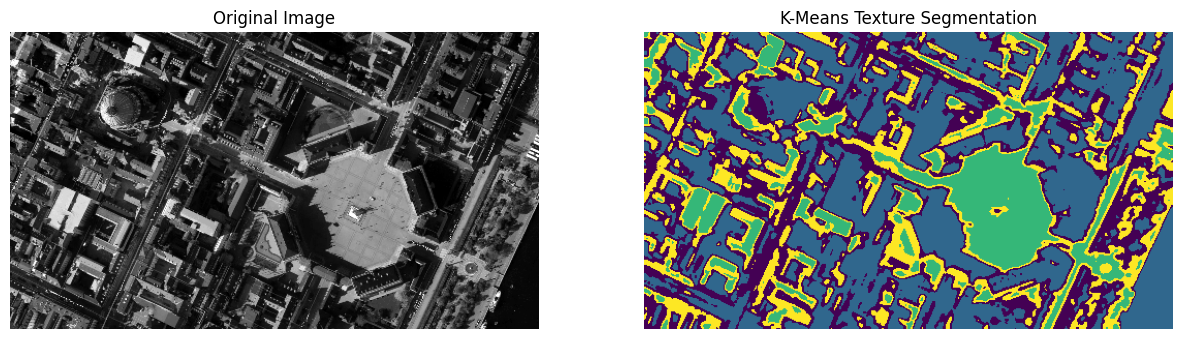

In [14]:
segmented_image = segment_real_image("/content/2018_09_17_first_batch_of_high_res_satellite_imagery_in_maptiler_cloud_1_183c427047.png", num_clusters=4)